In [107]:
import torch
import numpy as np
import os, sys
import shutil
import pickle
import cv2
from tqdm import tqdm
from sklearn.cluster import KMeans

sys.path.insert(0, 'src')
from utils.utils import ensure_dir
from utils.visualizations import plot

sys.path.insert(0, 'setup')
from setup_cifar10 import setup_cifar10 
# import cv2
# print(cv2.__version__)

In [125]:
cifar10_save_dir = os.path.join('saved', 'cifar10')
ensure_dir(cifar10_save_dir)

### Process CIFAR-10 to get rid of bytes

In [3]:
raw_cifar_dir = 'data/cifar-10-batches-py'
processed_cifar_dir = 'data/cifar10-processed'

if not os.path.exists(processed_cifar_dir):
    setup_cifar_10(
        raw_cifar_dir=raw_cifar_dir,
        processed_cifar_dir=processed_cifar_dir)
    print("Processing CIFAR10")
else:
    print("CIFAR-10 already processed at {}".format(processed_cifar_dir))
    

CIFAR-10 already processed at data/cifar10-processed


In [126]:
from torch.utils.data import Dataset
from torchvision import transforms
from utils.visualizations import show_image

class CIFAR10Dataset():
    def __init__(self,
                 cifar_dir, 
                 split):
                 # normalize=False,
                 # means=[0.4914, 0.4822, 0.4465],
                 # stds=[0.2471, 0.2435, 0.2616]):
        
        assert split in ['train', 'test'], "Invalid split '{}'. Must be 'train' or 'test'".format(split)
        if split == 'train':
            files = ['data_batch_{}'.format(i) for i in range(1,6)]
        else:
            files = ['test_batch']
            
        images = []
        labels = []
        for file in files:
            path = os.path.join(cifar_dir, file)
            data = pickle.load(open(path, 'rb'))
            cur_images = data['data']
            cur_images = np.reshape(cur_images, (-1, 3, 32, 32))
            images.append(cur_images)
            
            cur_labels = np.array(data['labels'])
            labels.append(cur_labels)
        
        self.images = np.concatenate(images, axis=0)
        self.images = np.transpose(self.images, (0, 2, 3, 1)) # N x H x W x C
        
#         if normalize:
#             means = np.tile(means, (*self.images.shape[:3], 1))
#             stds = np.tile(stds, (*self.images.shape[:3], 1))
            
#             self.images = (self.images - means) / stds
#             print(means.shape)
#             print(means[0, :, 0, 0])
            # self.images = 
        self.labels = np.concatenate(labels, axis=0)
        self.n_samples = len(self.labels)
        
    def get_images(self):
        return self.images

    def get_labels(self):
        return self.labels
        
    def __len__(self):
        return self.n_samples
    
train_dataset = CIFAR10Dataset(
    cifar_dir=processed_cifar_dir,
    split='train')
        
train_images = train_dataset.get_images()
train_labels = train_dataset.get_labels()

test_dataset = CIFAR10Dataset(
    cifar_dir=processed_cifar_dir,
    split='test')
test_images = test_dataset.get_images()
test_labels = test_dataset.get_labels()

### Probablyu wont use this dataset

In [ ]:
# class CIFAR10(Dataset):
#     def __init__(self,
#                  cifar_dir,
#                  split,
#                  to_tensor=True,
#                  normalize=True,
#                  means=[0.4914, 0.4822, 0.4465],
#                  stds=[0.2471, 0.2435, 0.2616]):
        
#         images = []
#         labels = []
#         assert split in ['train', 'test'], "Invalid split '{}'. Must be 'train' or 'test'".format(split)
#         if split == 'train':
#             files = ['data_batch_{}'.format(i) for i in range(1,6)]
#         else:
#             files = ['test_batch']
            
#         for file in files:
#             path = os.path.join(cifar_dir, file)
#             data = pickle.load(open(path, 'rb'))
#             cur_images = data['data']
#             cur_images = np.reshape(cur_images, (-1, 3, 32, 32))
#             images.append(cur_images)
            
#             cur_labels = np.array(data['labels'])
#             labels.append(cur_labels)
        
#         self.images = np.concatenate(images, axis=0)
#         self.images = np.transpose(self.images, (0, 2, 3, 1))
#         self.labels = np.concatenate(labels, axis=0)
#         self.n_samples = len(self.labels)
                
#         # Create transformations
#         self.transforms = [transforms.ToTensor()]  # changes dims H x W x C -> C x H x W and scales to [0, 1]
#         if normalize:
#             self.transforms.append(transforms.Normalize(means, stds))
#         self.transforms = transforms.Compose(self.transforms)
    
#     def __getitem__(self, idx):
#         image = self.transforms(self.images[idx])
#         label = self.labels[idx]
#         return image, label

#     def __len__(self):
#         return self.n_samples
        
# train_dataset = CIFAR10(
#     cifar_dir=processed_cifar_dir,
#     split='train',
#     to_tensor=False,
#     normalize=False)

# test_dataset = CIFAR10(
#     cifar_dir=processed_cifar_dir,
#     split='test',
#     to_tensor=False,
#     normalize=False)

### OpenCV's SIFT
Tutorial from [here](https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html)

In [144]:
MAX_FEATURES = 32
RESIZE = (128, 128)
descriptor_size = 128
debug = False


sift = cv2.SIFT_create()
train_keypoints = []
train_descriptors = []

images = {
    'train': train_images,
    'test': test_images
}
sift_data = {
    'train': {
        'keypoints': [],
        'descriptors': []
    },
    'test': {
        'keypoints': [],
        'descriptors': []
    }
}
for split in ['train', 'test']:
    print("Calculating keypoints and feature descriptors for CIFAR-10 {} split".format(split))
    split_images = images[split]
    split_keypoints = sift_data[split]['keypoints']
    split_descriptors = sift_data[split]['descriptors']
    for idx, image in enumerate(tqdm(split_images, total=len(split_images))):
        if debug and idx == 5:
            break
        # Image processing
        image_bw = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Calculate descriptors
        keypoints, descriptors = sift.detectAndCompute(image_bw, None)
        if debug:
            img2 = cv2.drawKeypoints(image, keypoints, None, color=(0, 255, 0), flags=0)
            plt.imshow(img2)
            plt.show()
        if len(keypoints) == 0:
            descriptors = np.zeros((1, descriptor_size), np.float32)
        keypoint_objs = []
        for keypoint in keypoints:
            keypoint_objs.append({
                'point': keypoint.pt,
                'size': keypoint.size,
                'angle': keypoint.angle,
                'response': keypoint.response,
                'octave': keypoint.octave,
                'class_id': keypoint.class_id
            })
        split_keypoints.append(keypoint_objs)
        split_descriptors.append(descriptors)
        
    sift_data[split]['keypoints'] = split_keypoints
    sift_data[split]['descriptors'] = split_descriptors


Calculating keypoints and feature descriptors for CIFAR-10 train split


100%|███████████████████████████████████| 50000/50000 [00:48<00:00, 1033.31it/s]


Calculating keypoints and feature descriptors for CIFAR-10 test split


100%|███████████████████████████████████| 10000/10000 [00:09<00:00, 1009.77it/s]


In [148]:
assert len(sift_data['test']['keypoints']) == len(test_images)
assert len(sift_data['test']['descriptors']) == len(test_images)
assert len(sift_data['train']['keypoints']) == len(train_images)
assert len(sift_data['train']['descriptors']) == len(train_images)
# assert 
sift_save_path = os.path.join(cifar10_save_dir, 'sift_keypoints_descriptors.pth')
if not os.path.exists(sift_save_path):
    torch.save(sift_data, sift_save_path)
    print("Saved keypoints & descriptors from train and test to {}".format(sift_save_path))
else:
    print("Path {} already exists".format(sift_save_path))

Saved keypoints & descriptors from train and test to saved/cifar10/sift_keypoints_descriptors.pth


### Cluster the feature descriptors

#### Hyperparameter search for the optimal number of clusters

In [ ]:
ks = [5, 10, 50, 75, 100, 150]
n_init = 10
inertias = []

train_descriptors = sift_data['train']['descriptors']
flat_train_descriptors = np.concatenate(train_descriptors, axis=0)
print(flat_train_descriptors.shape)
for k in ks:
    print("Calculating k-means for k={}".format(k))
    kmeans = KMeans(n_clusters=k, n_init=n_init)
    kmeans = kmeans.fit(flat_train_descriptors)
    inertias.append(kmeans.inertia_)
    
plot(
    xs=ks,
    ys=inertias)

#### Make clusters 

In [151]:
k = 75
sift_data = torch.load('saved/cifar10/sift_keypoints_descriptors.pth')
train_descriptors = sift_data['train']['descriptors']
print("Calculating kmeans clusters with k={}".format(k))
kmeans = KMeans(n_clusters=k, n_init=n_init)
kmeans = kmeans.fit(flat_train_descriptors)


Calculating kmeans clusters with k=75


In [152]:
kmeans_save_path = os.path.join(cifar10_save_dir, '{}means_descriptor_clusters.pth'.format(k))
if not os.path.exists(kmeans_save_path):
    torch.save(kmeans, kmeans_save_path)
    print("K-means with k={} saved to '{}".format(k, kmeans_save_path))
else:
    print("K-means model already saved to {}".format(kmeans_save_path))

K-means with k=75 saved to 'saved/cifar10/75means_descriptor_clusters.pth


#### For each descriptor in training set, create a histogram representing the features present

In [166]:
k = 75
kmeans = torch.load('saved/cifar10/{}means_descriptor_clusters.pth'.format(k))

histogram_vectors = []

debug = False
for idx, image_train_descriptors in enumerate(tqdm(train_descriptors, total=len(train_descriptors))):
    if debug and idx == 5:
        break
    n_descriptors = len(image_train_descriptors)
    descriptor_clusters = kmeans.predict(image_train_descriptors)
    histogram = np.zeros(k)
    for cluster_idx in descriptor_clusters:
        histogram[cluster_idx] += 1 / n_descriptors  # add 1/n_descriptors bc histogram will be normalized
        
    histogram_vectors.append(histogram)
histogram_vectors = np.stack(histogram_vectors, axis=0)

100%|███████████████████████████████████| 50000/50000 [00:13<00:00, 3789.28it/s]


In [168]:
# histogram_vectors = np.stack(histogram_vectors, axis=0)
print(histogram_vectors.shape)
train_histogram_vectors_save_path = os.path.join(cifar10_save_dir, 'train_histogram_vectors.pth')
if not os.path.exists(train_histogram_vectors_save_path):
    torch.save(histogram_vectors, train_histogram_vectors_save_path)
    print("Saved train histogram vectors to {}".format(train_histogram_vectors_save_path))
else:
    print("Histogram vectors already exists at {}".format(train_histogram_vectors_save_path))

(50000, 75)
Saved train histogram vectors to saved/cifar10/train_histogram_vectors.pth


In [164]:
# create or reuse dataloader for features for histogram vectors
# train linear layers on this input
# with labels being the model's labels
# ^ oh need to get a model and run it on CIFAR10 images

50000


### First use OpenCV's ORB feature descriptor

uint8
(128, 128, 3) <class 'numpy.ndarray'>


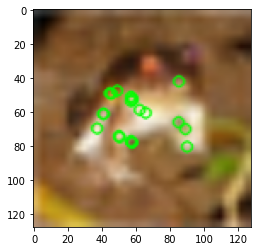

(21, 32)
uint8
(128, 128, 3) <class 'numpy.ndarray'>


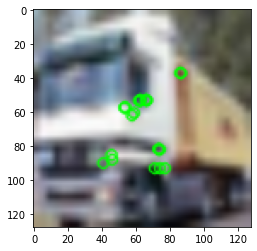

(21, 32)
uint8
(128, 128, 3) <class 'numpy.ndarray'>


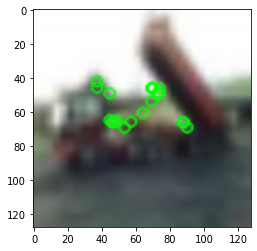

(21, 32)
uint8
(128, 128, 3) <class 'numpy.ndarray'>


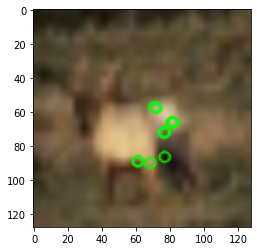

(12, 32)
uint8
(128, 128, 3) <class 'numpy.ndarray'>


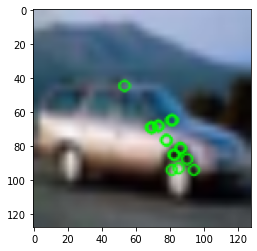

(18, 32)


In [95]:
MAX_FEATURES = 32
RESIZE = (128, 128)
import matplotlib.pyplot as plt

orb = cv2.ORB_create(MAX_FEATURES)
train_keypoints = []
train_descriptors = []
for idx, (image, label) in enumerate(zip(train_images, train_labels)):
    if idx == 5:
        break
    # image = image.numpy()
    # image = np.transpose(image, (1, 2, 0))
    image = cv2.resize(image, RESIZE)
    print(image.dtype)
    if image.dtype != 'uint8':
        image = (image * 255.0).astype(np.uint8)
    # image_bw = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    print(image.shape, type(image))
    keypoints, descriptors = orb.detectAndCompute(image, None)
    # keypoints_bw, descriptors_bw = orb.detectAndCompute(image_bw, None)
    # print((descriptors == descriptors_bw).all())
    img2 = cv2.drawKeypoints(image, keypoints, None, color=(0, 255, 0), flags=0)
    plt.imshow(img2)
    plt.show()
    print(descriptors.shape)
    train_keypoints.append(keypoints)
    train_descriptors.append(descriptors)

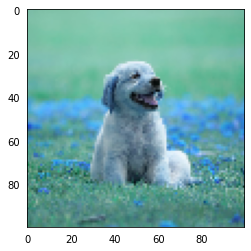

<class 'numpy.ndarray'> (100, 100, 3)
(4, 32)


In [49]:
img = cv2.imread('data/cifar10-processed/dog.jpg')
img = cv2.resize(img, (100, 100))
show_image(img)
print(type(img), img.shape)
keypoints, descriptors = orb.detectAndCompute(img, None)
print(descriptors.shape)